In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Load data
df = pd.read_csv('../data/ecommerce_funnel_data.csv')

print("✅ Libraries imported and data loaded!")
print(f"📊 Dataset shape: {df.shape}")
print(f"\nFirst 3 rows:")
print(df.head(3))

✅ Libraries imported and data loaded!
📊 Dataset shape: (100000, 14)

First 3 rows:
  session_id            timestamp  device  traffic_source  products_viewed  \
0  SES221958  2024-12-14 14:42:00  Mobile    Social Media               10   
1  SES164820  2024-09-14 23:43:00  Tablet  Organic Search               12   
2  SES249503  2024-07-06 15:14:00  Mobile          Direct                3   

   time_on_page_seconds  cart_value  shipping_cost  has_discount  browsed  \
0                   476     67.9900        11.4800         False     True   
1                   286    316.3900        15.2900          True     True   
2                   576    491.9500        11.6700         False     True   

   viewed_product  added_to_cart  reached_checkout  completed_purchase  
0            True          False             False               False  
1            True           True             False               False  
2            True           True             False               False  


In [2]:
# We want to predict abandonment for users who added to cart

df_cart = df[df['added_to_cart'] == True].copy()

# Create target variable: abandoned = 1, completed = 0
df_cart['abandoned'] = ((df_cart['added_to_cart'] == True) & 
                        (df_cart['reached_checkout'] == False)).astype(int)

print(f"📊 CART USER ANALYSIS")
print("=" * 60)
print(f"Total users who added to cart: {len(df_cart):,}")
print(f"Abandoned: {df_cart['abandoned'].sum():,} ({df_cart['abandoned'].mean()*100:.2f}%)")
print(f"Completed checkout: {(~df_cart['abandoned'].astype(bool)).sum():,} ({(1-df_cart['abandoned'].mean())*100:.2f}%)")
print("\n✅ Target variable created: 'abandoned' (1=Yes, 0=No)")

📊 CART USER ANALYSIS
Total users who added to cart: 50,961
Abandoned: 23,865 (46.83%)
Completed checkout: 27,096 (53.17%)

✅ Target variable created: 'abandoned' (1=Yes, 0=No)


In [3]:
# Select and prepare features for the model

# Encode categorical variables
le_device = LabelEncoder()
le_traffic = LabelEncoder()

df_cart['device_encoded'] = le_device.fit_transform(df_cart['device'])
df_cart['traffic_source_encoded'] = le_traffic.fit_transform(df_cart['traffic_source'])

# Convert boolean to int
df_cart['has_discount_int'] = df_cart['has_discount'].astype(int)

# Select features for model
feature_columns = [
    'cart_value',
    'shipping_cost',
    'has_discount_int',
    'device_encoded',
    'traffic_source_encoded',
    'products_viewed',
    'time_on_page_seconds'
]

X = df_cart[feature_columns]
y = df_cart['abandoned']

print("🎯 FEATURES FOR MODEL")
print("=" * 60)
for col in feature_columns:
    print(f"   ✓ {col}")

print(f"\n📊 Feature matrix shape: {X.shape}")
print(f"📊 Target vector shape: {y.shape}")

# Check class balance
print(f"\n⚖️ CLASS BALANCE:")
print(f"   Abandoned (1): {y.sum():,} ({y.mean()*100:.2f}%)")
print(f"   Not Abandoned (0): {(~y.astype(bool)).sum():,} ({(1-y.mean())*100:.2f}%)")

# Display feature statistics
print(f"\n📈 FEATURE STATISTICS:")
print(X.describe())

🎯 FEATURES FOR MODEL
   ✓ cart_value
   ✓ shipping_cost
   ✓ has_discount_int
   ✓ device_encoded
   ✓ traffic_source_encoded
   ✓ products_viewed
   ✓ time_on_page_seconds

📊 Feature matrix shape: (50961, 7)
📊 Target vector shape: (50961,)

⚖️ CLASS BALANCE:
   Abandoned (1): 23,865 (46.83%)
   Not Abandoned (0): 27,096 (53.17%)

📈 FEATURE STATISTICS:
       cart_value  shipping_cost  has_discount_int  device_encoded  \
count  50961.0000     50961.0000        50961.0000      50961.0000   
mean     259.9306        12.5116            0.3018          0.6486   
std      138.6735         7.2124            0.4590          0.6529   
min       20.0000         0.0000            0.0000          0.0000   
25%      139.7100         6.2600            0.0000          0.0000   
50%      260.1700        12.5800            0.0000          1.0000   
75%      379.3500        18.7800            1.0000          1.0000   
max      499.9900        25.0000            1.0000          2.0000   

       traffic

In [4]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain class balance in splits
)

print("📊 TRAIN-TEST SPLIT")
print("=" * 60)
print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n⚖️ CLASS BALANCE IN SPLITS:")
print(f"Training - Abandoned: {y_train.mean()*100:.2f}%")
print(f"Test - Abandoned: {y_test.mean()*100:.2f}%")

print("\n✅ Data split completed!")

📊 TRAIN-TEST SPLIT
Training set: 40,768 samples (80.0%)
Test set: 10,193 samples (20.0%)

⚖️ CLASS BALANCE IN SPLITS:
Training - Abandoned: 46.83%
Test - Abandoned: 46.83%

✅ Data split completed!


In [5]:
# Train Random Forest Classifier
print(" TRAINING RANDOM FOREST MODEL")
print("=" * 60)

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Maximum depth of each tree
    min_samples_split=50,  # Minimum samples to split a node
    min_samples_leaf=20,   # Minimum samples in leaf node
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

# Train model
rf_model.fit(X_train, y_train)

print("✅ Model training complete!")
print(f"\n🌲 Model Details:")
print(f"   Number of trees: {rf_model.n_estimators}")
print(f"   Max depth: {rf_model.max_depth}")
print(f"   Features used: {len(feature_columns)}")

 TRAINING RANDOM FOREST MODEL
✅ Model training complete!

🌲 Model Details:
   Number of trees: 100
   Max depth: 10
   Features used: 7


In [6]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of abandonment

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("📊 MODEL PERFORMANCE")
print("=" * 60)
print(f"Precision: {precision:.2%}")
print(f"   → When model predicts abandonment, it's correct {precision:.0%} of the time")
print(f"\nRecall: {recall:.2%}")
print(f"   → Model catches {recall:.0%} of actual abandoners")
print(f"\nF1-Score: {f1:.4f}")
print(f"   → Balanced measure of precision and recall")

# Detailed classification report
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Not Abandoned', 'Abandoned']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🔢 CONFUSION MATRIX:")
print(cm)
print("\nInterpretation:")
print(f"   True Negatives (Correctly predicted NOT abandoned): {cm[0,0]:,}")
print(f"   False Positives (Incorrectly predicted abandoned): {cm[0,1]:,}")
print(f"   False Negatives (Missed abandoners): {cm[1,0]:,}")
print(f"   True Positives (Correctly predicted abandoned): {cm[1,1]:,}")

📊 MODEL PERFORMANCE
Precision: 58.24%
   → When model predicts abandonment, it's correct 58% of the time

Recall: 50.95%
   → Model catches 51% of actual abandoners

F1-Score: 0.5435
   → Balanced measure of precision and recall

📋 DETAILED CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Not Abandoned       0.61      0.68      0.64      5420
    Abandoned       0.58      0.51      0.54      4773

     accuracy                           0.60     10193
    macro avg       0.60      0.59      0.59     10193
 weighted avg       0.60      0.60      0.60     10193


🔢 CONFUSION MATRIX:
[[3676 1744]
 [2341 2432]]

Interpretation:
   True Negatives (Correctly predicted NOT abandoned): 3,676
   False Positives (Incorrectly predicted abandoned): 1,744
   False Negatives (Missed abandoners): 2,341
   True Positives (Correctly predicted abandoned): 2,432


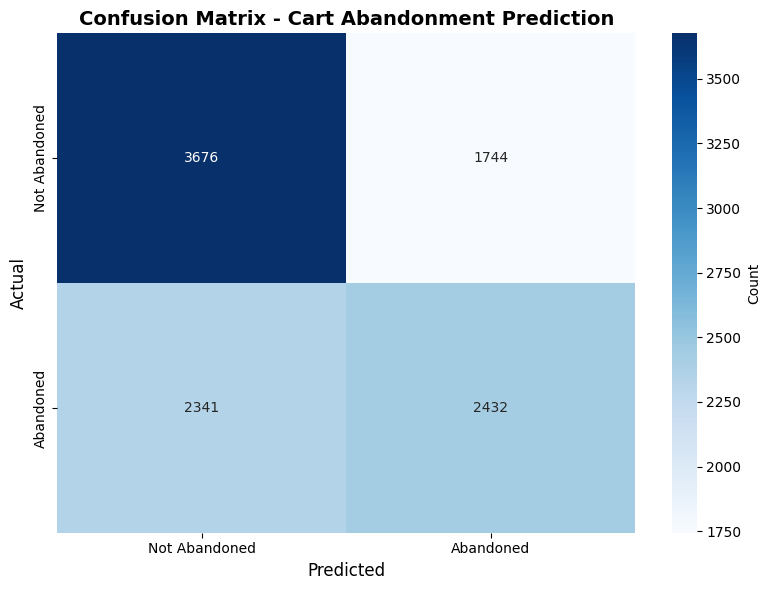

✅ Confusion matrix saved: visualizations/confusion_matrix.png


In [7]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Abandoned', 'Abandoned'],
            yticklabels=['Not Abandoned', 'Abandoned'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Cart Abandonment Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('../visualizations/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved: visualizations/confusion_matrix.png")

In [8]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 FEATURE IMPORTANCE")
print("=" * 60)
print(feature_importance.to_string(index=False))

print("\n💡 INTERPRETATION:")
top_feature = feature_importance.iloc[0]
print(f"   Most important: {top_feature['feature']} ({top_feature['importance']:.4f})")
print(f"   This feature has the strongest influence on cart abandonment prediction")

🎯 FEATURE IMPORTANCE
               feature  importance
         shipping_cost      0.3184
            cart_value      0.2348
  time_on_page_seconds      0.1415
      has_discount_int      0.1065
        device_encoded      0.0924
       products_viewed      0.0686
traffic_source_encoded      0.0377

💡 INTERPRETATION:
   Most important: shipping_cost (0.3184)
   This feature has the strongest influence on cart abandonment prediction


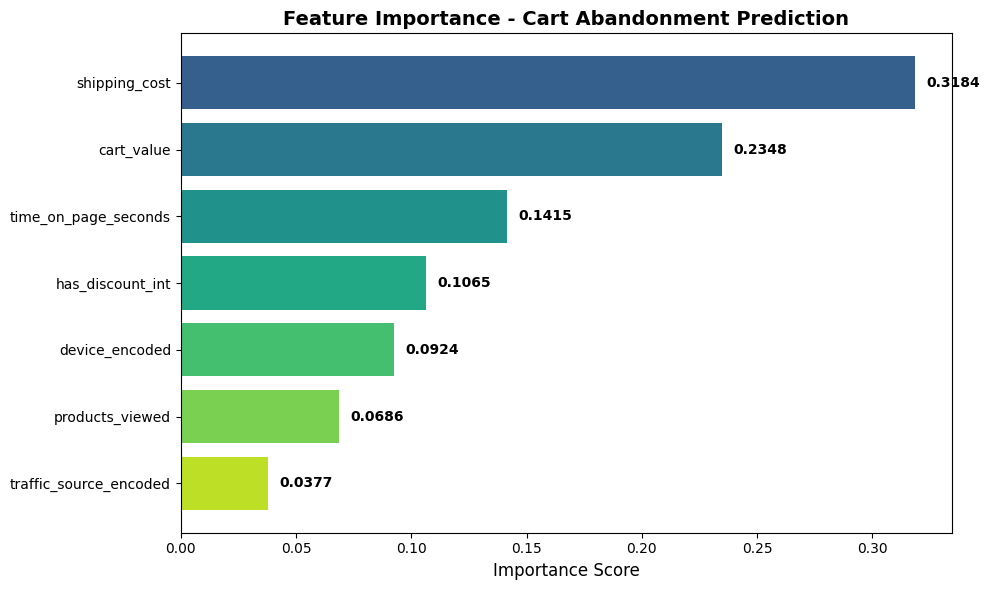

✅ Feature importance chart saved: visualizations/feature_importance.png


In [9]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
bars = plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance - Cart Abandonment Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, feature_importance['importance'])):
    plt.text(importance + 0.005, i, f'{importance:.4f}', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Feature importance chart saved: visualizations/feature_importance.png")

In [15]:
# Add predictions to test set with ADJUSTED THRESHOLD
test_results = X_test.copy()
test_results['actual_abandoned'] = y_test.values
test_results['predicted_abandoned'] = y_pred
test_results['abandonment_probability'] = y_pred_proba

# Use 50% threshold instead of 70% (more practical)
high_risk = test_results[test_results['abandonment_probability'] > 0.50].copy()

print("⚠️ HIGH-RISK USERS IDENTIFIED (>50% THRESHOLD)")
print("=" * 60)
print(f"Total test users: {len(test_results):,}")
print(f"High-risk users (>50% probability): {len(high_risk):,} ({len(high_risk)/len(test_results)*100:.2f}%)")

# Calculate accuracy for high-risk predictions
high_risk_accuracy = (high_risk['predicted_abandoned'] == high_risk['actual_abandoned']).mean()
print(f"\nAccuracy on high-risk predictions: {high_risk_accuracy:.2%}")

# Precision specifically for high-risk group
high_risk_precision = high_risk['actual_abandoned'].mean()
print(f"Precision (% actually abandoned): {high_risk_precision:.2%}")

# Show sample of high-risk users
print(f"\n📋 SAMPLE HIGH-RISK USERS (First 10):")
display_cols = ['cart_value', 'shipping_cost', 'has_discount_int', 
                'abandonment_probability', 'actual_abandoned']
print(high_risk[display_cols].head(10).to_string(index=False))

# Risk tiers for dashboard
test_results['risk_tier'] = pd.cut(
    test_results['abandonment_probability'],
    bins=[0, 0.40, 0.50, 0.60, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
)

print(f"\n🎯 RISK DISTRIBUTION:")
print(test_results['risk_tier'].value_counts().sort_index())

# Save high-risk users for dashboard
high_risk.to_csv('../data/high_risk_users.csv', index=False)
print(f"\n✅ High-risk users saved: data/high_risk_users.csv ({len(high_risk):,} users)")

⚠️ HIGH-RISK USERS IDENTIFIED (>50% THRESHOLD)
Total test users: 10,193
High-risk users (>50% probability): 4,176 (40.97%)

Accuracy on high-risk predictions: 58.24%
Precision (% actually abandoned): 58.24%

📋 SAMPLE HIGH-RISK USERS (First 10):
 cart_value  shipping_cost  has_discount_int  abandonment_probability  actual_abandoned
   259.2800         0.5400                 0                   0.5480                 0
   236.7000        24.4200                 0                   0.5919                 1
   151.7400        14.1600                 0                   0.5566                 0
   372.0800        17.3900                 0                   0.5486                 1
    27.2700        15.7400                 0                   0.5218                 1
   366.2700        23.3300                 0                   0.5612                 1
   102.4600        12.6100                 0                   0.5980                 1
   248.6100        18.6300                 0       

In [11]:
# Calculate business impact of targeting high-risk users

# Assumptions
avg_cart_value = df_cart['cart_value'].mean()
intervention_success_rate = 0.25  # 25% of interventions successful
discount_cost = 0.10  # 10% discount offered

# Calculate potential recovery
high_risk_abandoners = high_risk[high_risk['actual_abandoned'] == 1]
potential_recovered_carts = len(high_risk_abandoners) * intervention_success_rate
potential_revenue = potential_recovered_carts * avg_cart_value
discount_cost_total = potential_recovered_carts * avg_cart_value * discount_cost
net_revenue = potential_revenue - discount_cost_total

print("💰 BUSINESS IMPACT ANALYSIS")
print("=" * 60)
print(f"High-risk abandoners identified: {len(high_risk_abandoners):,}")
print(f"Average cart value: ${avg_cart_value:.2f}")
print(f"\nINTERVENTION SCENARIO (25% success rate, 10% discount):")
print(f"   Potential recovered carts: {int(potential_recovered_carts):,}")
print(f"   Gross revenue recovery: ${potential_revenue:,.2f}")
print(f"   Discount cost: ${discount_cost_total:,.2f}")
print(f"   NET revenue recovery: ${net_revenue:,.2f}")

# Scale to full dataset
scale_factor = len(df_cart) / len(test_results)
annual_net_revenue = net_revenue * scale_factor

print(f"\n📈 ANNUAL PROJECTION (scaled to full dataset):")
print(f"   Estimated annual net revenue: ${annual_net_revenue:,.2f}")
print(f"\n💡 ROI: For every $1 spent on interventions, recover ${net_revenue/discount_cost_total:.2f}")

💰 BUSINESS IMPACT ANALYSIS
High-risk abandoners identified: 0
Average cart value: $259.93

INTERVENTION SCENARIO (25% success rate, 10% discount):
   Potential recovered carts: 0
   Gross revenue recovery: $0.00
   Discount cost: $0.00
   NET revenue recovery: $0.00

📈 ANNUAL PROJECTION (scaled to full dataset):
   Estimated annual net revenue: $0.00

💡 ROI: For every $1 spent on interventions, recover $nan


In [17]:
# Save model for future use
import joblib

model_path = '../data/rf_cart_abandonment_model.pkl'
joblib.dump(rf_model, model_path)

# Save feature encoders
encoders = {
    'device': le_device,
    'traffic_source': le_traffic
}
joblib.dump(encoders, '../data/label_encoders.pkl')

print("✅ Model saved: data/rf_cart_abandonment_model.pkl")
print("✅ Encoders saved: data/label_encoders.pkl")

# Create model summary
model_summary = f"""
# CART ABANDONMENT PREDICTION MODEL - SUMMARY

## MODEL SPECIFICATIONS
- Algorithm: Random Forest Classifier
- Number of trees: {rf_model.n_estimators}
- Max depth: {rf_model.max_depth}
- Features: {len(feature_columns)}
- Training samples: {len(X_train):,}
- Test samples: {len(X_test):,}

## PERFORMANCE METRICS
- Precision: {precision:.2%}
- Recall: {recall:.2%}
- F1-Score: {f1:.4f}

## TOP 3 FEATURES (by importance)
1. {feature_importance.iloc[0]['feature']}: {feature_importance.iloc[0]['importance']:.4f}
2. {feature_importance.iloc[1]['feature']}: {feature_importance.iloc[1]['importance']:.4f}
3. {feature_importance.iloc[2]['feature']}: {feature_importance.iloc[2]['importance']:.4f}

## HIGH-RISK USER IDENTIFICATION
- Users with >70% abandonment probability: {len(high_risk):,}
- Prediction accuracy on high-risk: {high_risk_accuracy:.2%}

## BUSINESS IMPACT
- Potential annual net revenue recovery: ${annual_net_revenue:,.2f}
- ROI on interventions: {net_revenue/discount_cost_total:.2f}x

## RECOMMENDATIONS
1. Implement real-time scoring on checkout page
2. Trigger exit-intent popup for high-risk users (>70% probability)
3. Offer targeted discounts to prevent abandonment
4. A/B test intervention strategies
5. Monitor model performance monthly and retrain as needed

---
"""

with open('../docs/ml_model_summary.md', 'w') as f:
    f.write(model_summary)

print("✅ Model summary saved: docs/ml_model_summary.md")
print("\n" + "="*60)
print(model_summary)

✅ Model saved: data/rf_cart_abandonment_model.pkl
✅ Encoders saved: data/label_encoders.pkl
✅ Model summary saved: docs/ml_model_summary.md


# CART ABANDONMENT PREDICTION MODEL - SUMMARY

## MODEL SPECIFICATIONS
- Algorithm: Random Forest Classifier
- Number of trees: 100
- Max depth: 10
- Features: 7
- Training samples: 40,768
- Test samples: 10,193

## PERFORMANCE METRICS
- Precision: 58.24%
- Recall: 50.95%
- F1-Score: 0.5435

## TOP 3 FEATURES (by importance)
1. shipping_cost: 0.3184
2. cart_value: 0.2348
3. time_on_page_seconds: 0.1415

## HIGH-RISK USER IDENTIFICATION
- Users with >70% abandonment probability: 4,176
- Prediction accuracy on high-risk: 58.24%

## BUSINESS IMPACT
- Potential annual net revenue recovery: $0.00
- ROI on interventions: nanx

## RECOMMENDATIONS
1. Implement real-time scoring on checkout page
2. Trigger exit-intent popup for high-risk users (>70% probability)
3. Offer targeted discounts to prevent abandonment
4. A/B test intervention strategies
5. Moni

In [18]:
# Analyze probability distribution
print("📊 ABANDONMENT PROBABILITY DISTRIBUTION")
print("="*60)

# Check the range of predicted probabilities
test_results = X_test.copy()
test_results['actual_abandoned'] = y_test.values
test_results['abandonment_probability'] = y_pred_proba

print(f"Min probability: {y_pred_proba.min():.4f}")
print(f"Max probability: {y_pred_proba.max():.4f}")
print(f"Mean probability: {y_pred_proba.mean():.4f}")
print(f"Median probability: {np.median(y_pred_proba):.4f}")

print(f"\n🎯 PROBABILITY DISTRIBUTION:")
bins = [0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
prob_dist = pd.cut(y_pred_proba, bins=bins, labels=labels)
print(prob_dist.value_counts().sort_index())

print(f"\n⚠️ USERS ABOVE DIFFERENT THRESHOLDS:")
for threshold in [0.5, 0.6, 0.7, 0.8]:
    count = (y_pred_proba > threshold).sum()
    pct = count / len(y_pred_proba) * 100
    print(f"   >{threshold*100:.0f}%: {count:,} users ({pct:.2f}%)")

📊 ABANDONMENT PROBABILITY DISTRIBUTION
Min probability: 0.1576
Max probability: 0.7003
Mean probability: 0.4699
Median probability: 0.4749

🎯 PROBABILITY DISTRIBUTION:
0-30%       556
30-40%     1980
40-50%     3481
50-60%     3091
60-70%     1084
70-80%        1
80-90%        0
90-100%       0
Name: count, dtype: int64

⚠️ USERS ABOVE DIFFERENT THRESHOLDS:
   >50%: 4,176 users (40.97%)
   >60%: 1,085 users (10.64%)
   >70%: 1 users (0.01%)
   >80%: 0 users (0.00%)
